In [2]:
import cv2
import os
import shutil
import colorsys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from glob import glob

In [3]:
def findLimits(frame):
    ''' Let's find the red objects in the scene ''' 
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h,_,_ = cv2.split(hsv_frame)
    lower_red = np.array([0,150,150])
    upper_red = np.array([20,255,255])
    red = cv2.inRange(hsv_frame, lower_red, upper_red)
    red = cv2.bitwise_not(red)
    
    # Finding the possition of the two red marks in the scene
    keypoints = detector2.detect(red)
    marks = []
    copied_im = cv2.cvtColor(red.copy(), cv2.COLOR_GRAY2BGR)
    for k in keypoints:
        x, y = k.pt
        marks.append((int(x), int(y)))
    return marks

def isEmpty(scene):
    ''' Checks if in the current frame there is someone using the histogram of a blank laboratory '''
    hsv_scene = cv2.cvtColor(scene,cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_scene)
    H_array = H[S > 100].flatten()
    val, pos = np.histogram(H_array, 18)
    val[[0,3]] = 0
#     print(val[[4,5,7,8,12,13,14,15,16]].max())
    return val.max()<1000

def create_dir(folder, force=True, verbose=False):
    '''   Create a directory if it doesn't exist  '''
    try:
        os.makedirs(folder)
        if verbose: print('Directory {} created succesfully.'.format(folder))   
    except:
        if force:
            if verbose: print('{} already exists. Creating a new one'.format(folder))
            shutil.rmtree(folder)
            os.makedirs(folder)
        else:
            if verbose: print('{} already exists.'.format(folder))
            pass

def bkgrd_hsv_substraction(frgrd, bkgrd):
    ''' Performs background substraction using the HLS color space '''
    bkgrd_hsv = cv2.cvtColor(bkgrd, cv2.COLOR_BGR2HLS)
    frgrd_hsv = cv2.cvtColor(frgrd, cv2.COLOR_BGR2HLS)

    diff = cv2.subtract(bkgrd_hsv, frgrd_hsv)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, raw = cv2.threshold(diff_gray, 15, 255, cv2.THRESH_BINARY)
    if diff_gray.sum()> 400000:
        closed = fine_mask(raw)
        blured = cv2.GaussianBlur(closed,(3,3),0)
        return True, raw, closed, blured
    else:
        return False, None, None, None

def isBackground(frgnd, bkgnd, th=1):
    bkgrd_hsv = cv2.cvtColor(bkgnd, cv2.COLOR_BGR2Lab)
    frgrd_hsv = cv2.cvtColor(frgnd, cv2.COLOR_BGR2Lab)

    diff = cv2.subtract(bkgrd_hsv, frgrd_hsv)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    return diff.sum() / 1000000

def com_his(frame, background, th=5):
    hsv_scene = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_scene)
    H_array = H[S > 100].flatten()
    val1, pos = np.histogram(H_array, 18)
#     print(val1)

    hsv_scene = cv2.cvtColor(background,cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_scene)
    H_array = H[S > 100].flatten()
    val2, pos = np.histogram(H_array, 18)
#     print(val2)
    return np.linalg.norm(val2 - val1) //1000 > th

kernel = np.ones((5,5),np.uint8)
def bkgrd_Lab_substraction(frame, background, th=5):
    ''' Performs background substraction using the Lab color space, which helps to reduce light noise '''
    bkgrd_h = (cv2.cvtColor(background, cv2.COLOR_BGR2Lab))
    frgrd_h = (cv2.cvtColor(frame, cv2.COLOR_BGR2Lab))

    diff = cv2.subtract(bkgrd_h, frgrd_h)
    diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, diff = cv2.threshold(diff, 5, 255, cv2.THRESH_BINARY)
    diff = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel)
    if diff.sum() / 1000000 > th:
        closed = fine_mask(diff)
        blured = cv2.GaussianBlur(closed,(3,3),0)
        closed = cv2.multiply(diff, closed)
        return True, diff, closed, blured
    else:
        return False, None, None, None
    
def fine_mask(mask):
    ''' Takes a raw mask as input and returns the biggest contour mask '''
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    c = max(contours, key = cv2.contourArea)
    out = np.zeros_like(mask)
    out = cv2.drawContours(out, [c], 0, 255, -1)
    return out


def random_colors(N, bright=True):
    ''' Generate random colors  '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # random.shuffle(colors)
    return colors

color = random_colors(1)[0]

def apply_mask(frame, mask, color, alpha=0.5):
    ''' Apply the given mask to the image '''
    image = frame.copy()
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [11]:
clips_directory = '/home/christian/Documents/Datasets/clips/'
raw_directory = '/home/christian/Documents/Datasets/OAKGait20'
subjects = ['001','002','003','004','005','001','007']
np.array(subjects[1:])

array(['002', '003', '004', '005', '001', '007'], dtype='<U3')

In [12]:
views = ['120']
walks = {'nm':'nm.mp4', 'bg':'bg.mp4', 'cl':'cl.mp4'}
# walks = {'cl':'cl.mp4'}
# walks = {'nm':'nm.mp4'}
# walks = {'bg':'bg.mp4'}

In [14]:
subject_new = False   # Creates a new directory for each subject [001, ... , ]
walk_new = True       # Creates a new directory for each walking [nm, bg, cl]
empty_frame = 90    # True if the first frame is background
already_background = False
for view in views:
    print(f'PROCESSING VIEW: {view}')
#     for subject in ['006', '007']:
    for subject in subjects:
        for walk, file in walks.items():
            print(f'Processing subject:{subject} walking: {walk} view: {view}')
            video_path = os.path.join(raw_directory, view, subject, file)
            cap = cv2.VideoCapture(video_path)
#             wait = int(1000 / cap.get(cv2.CAP_PROP_FPS))

            sub_dir = os.path.join(clips_directory, view, str(subject).zfill(3))
            create_dir(sub_dir, force=subject_new)

            clip_dir = os.path.join(clips_directory, view, str(subject).zfill(3), walk)
            create_dir(clip_dir, force=walk_new)

            # Identify the background of each sequence using the 'isEmpty()' function
            cnt = 0
            background = None

            while True:
                ret, first = cap.read()
                if ret:
                    if cnt == empty_frame:
                        background = first
                        break
                    cnt+=1
                else:
                    print('Not background fount')
                    break
            # Saving the background image
            back_name = os.path.join(clip_dir, f'background.png')
            cv2.imwrite(back_name, background)

            # Defining parameters to split each video
            cap.set(cv2.CAP_PROP_POS_FRAMES, 90)
            cnt = 0
            nwalking = 1
            isWalking = False
            x = deque(12*[True],12)

            # Getting parameters for the video clips
            codec = cv2.VideoWriter_fourcc('M','J','P','G')
            fwidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            fheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            while True:
                ret, scene = cap.read()
                if ret:
                    if cnt%3 == 0:
                        diff,_,_,_ = bkgrd_Lab_substraction(scene, background, th=15)
#                         diff = com_his(scene, background, th=15)
#                         cv2.putText(scene, str(diff), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

                        x.appendleft(not diff) 
#                         if np.mean(np.array([x[1], x[2], x[3], x[4], x[5], x[6]])) > 0.8:
                        #print(np.average(x))
                        if np.average(x)>0.7:
                            if isWalking:
                                print(f'|')
                                isWalking = False
                                out.release()
                        elif not isWalking:
                            print(f'Sequence {nwalking}', end='')
                            isWalking = True
                            clip_name = os.path.join(clip_dir, f'{walk}-{str(nwalking).zfill(2)}.avi')
                            out = cv2.VideoWriter(clip_name, codec, fps, (fwidth,fheight))
                            nwalking +=1
                    if isWalking:
                        out.write(scene)
                        if cnt%10==0: print('.', end='')
                    cnt+=1         
                    #cv2.imshow(f'Subject {subject}', cv2.resize(scene,(300,300)))
                else:
                    break
                if cv2.waitKey(1) == ord('q'):
                    break
            out.release()
            cap.release()
            cv2.destroyAllWindows()

PROCESSING VIEW: 120
Processing subject:001 walking: nm view: 120
Sequence 1............|
Sequence 2............|
Sequence 3...........|
Sequence 4...........|
Sequence 5...........|
Sequence 6...........|
Processing subject:001 walking: bg view: 120
Sequence 1..........|
Sequence 2...........|
Sequence 3...........|
Sequence 4...........|
Sequence 5...........|
Sequence 6...........|
Processing subject:001 walking: cl view: 120
Sequence 1...........|
Sequence 2...........|
Sequence 3...........|
Sequence 4...........|
Sequence 5...........|
Sequence 6............|
Processing subject:002 walking: nm view: 120
Sequence 1...........|
Sequence 2............|
Sequence 3............|
Sequence 4................|
Sequence 5..............|
Sequence 6..............|
Processing subject:002 walking: bg view: 120
Sequence 1...........|
Sequence 2.............|
Sequence 3............|
Sequence 4.............|
Sequence 5............|
Sequence 6.............|
Processing subject:002 walking: cl view: 

NameError: name 'background' is not defined

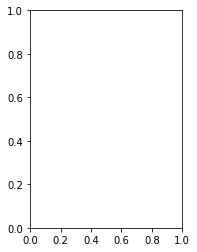

In [6]:
cap = cv2.VideoCapture('/home/christian/Documents/Datasets/OAKGait8/color/090/000/nm.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 100)
ret, frame = cap.read()
plt.subplot(121); plt.imshow(background[:,:,::-1])
plt.subplot(122); plt.imshow(frame[:,:,::-1])

In [13]:
images_dir = '/home/christian/Documents/Datasets/OAKGait8/frames'
frs_dir = 'rgb/'
mks_dir = 'masks/'
verbose = True
subjects = ['001', '002', '003', '004', '005', '007']
nclips = {'nm':6, 'bg':4, 'cl':4}

In [8]:
views = ['060', '075', '090', '105', '120']
#views = ['105', '120']
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    print(f'PROCESSING VIEW: {view}')
#     subjects = sorted(os.listdir(os.path.join(clips_directory, view)))
    for subject in subjects:
#     for subject in ['004']:
        print(f'Processing subject: {subject} view: {view}....                                  ')
        create_dir(os.path.join(frames_dir, subject), force=True)
        create_dir(os.path.join(masks_dir, subject), force=True)

        subject_dir = os.path.join(clips_directory, view, subject)
        walks = os.listdir(subject_dir)
        
        for j, walk in enumerate(['nm', 'bg', 'cl']):
#         for j, walk in enumerate(['nm']):

            walk_dir = os.path.join(subject_dir, walk)
            background = cv2.imread(os.path.join(walk_dir, f'background.png'))
            clips = sorted(os.listdir(walk_dir))
            
            save_back_path = os.path.join(frames_dir, subject, f'{walk}-background.png')
            cv2.imwrite(save_back_path, background)
            
            for i, clip in enumerate(clips):
                if clip[-4:] == '.avi' and nclips[walk]>=i:
                    clip_path = os.path.join(walk_dir, clip)
                    sub_dir = os.path.join(frames_dir, subject, walk, clip.split('.')[0])
                    mask_dir = os.path.join(masks_dir, subject, walk, clip.split('.')[0])
                    create_dir(sub_dir, force=True)
                    create_dir(mask_dir, force=True)
                    print(sub_dir, end='\r')
                    cap = cv2.VideoCapture(clip_path)
                    cnt = 0
                    while True:
                        ret, frame = cap.read()
                        if ret:
                            ok, diff_gray, closed, blured = bkgrd_Lab_substraction(frame, background)
                            if ok:
                                cnt +=1
                                frame_path = f'{sub_dir}/{str(cnt).zfill(4)}.png'
                                mask_path = f'{mask_dir}/{str(cnt).zfill(4)}.png'
                                frame = cv2.resize(frame, (0,0), fx=0.5, fy=0.5)
                                closed = cv2.resize(closed, (0,0), fx=0.5, fy=0.5)
                                cv2.imwrite(frame_path, frame)
                                cv2.imwrite(mask_path, closed)
                                if verbose:
                                    masked = apply_mask(frame.copy(), closed.astype('bool'), color)
#                                     cv2.imshow('frame', masked)
                        else:
                            break
                        if cv2.waitKey(1) == ord('q'):
                            break
                    cap.release()
    print('', end="\r")
cv2.destroyAllWindows()

PROCESSING VIEW: 060
Processing subject: 001 view: 060....                                  
Processing subject: 002 view: 060....                                  
Processing subject: 003 view: 060....                                  
Processing subject: 004 view: 060....                                  
Processing subject: 005 view: 060....                                  
Processing subject: 007 view: 060....                                  
PROCESSING VIEW: 075ait8/frames/060/rgb/007/cl/cl-04
Processing subject: 001 view: 075....                                  
Processing subject: 002 view: 075....                                  
Processing subject: 003 view: 075....                                  
Processing subject: 004 view: 075....                                  
Processing subject: 005 view: 075....                                  
Processing subject: 007 view: 075....                                  
PROCESSING VIEW: 090ait8/frames/075/rgb/007/cl/cl-04
Processin

SHOWING VIEW: 060
Showing subject: 001 view: 060


[ WARN:0@3673.011] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/christian/OAKGait8/frames/060/masks/001/bg/bg-04/0040.png'): can't open/read file: check file path/integrity


Error opening


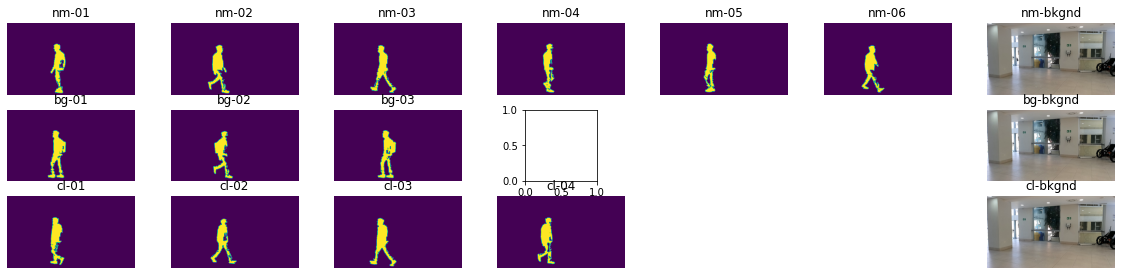

Showing subject: 002 view: 060


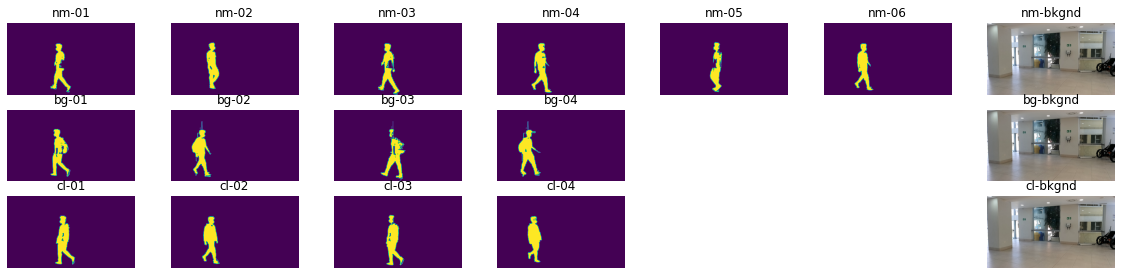

Showing subject: 003 view: 060


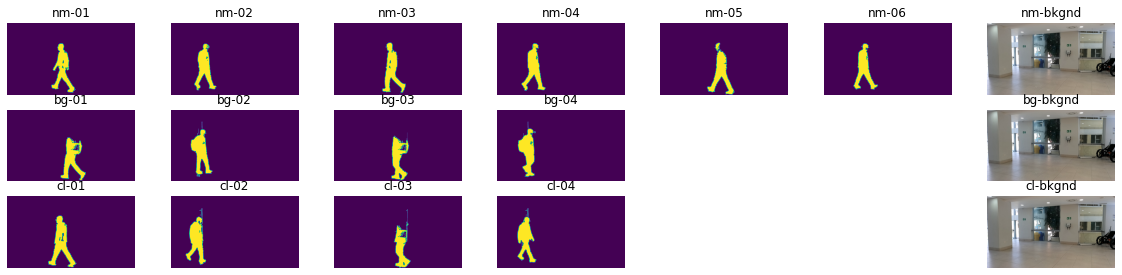

Showing subject: 004 view: 060


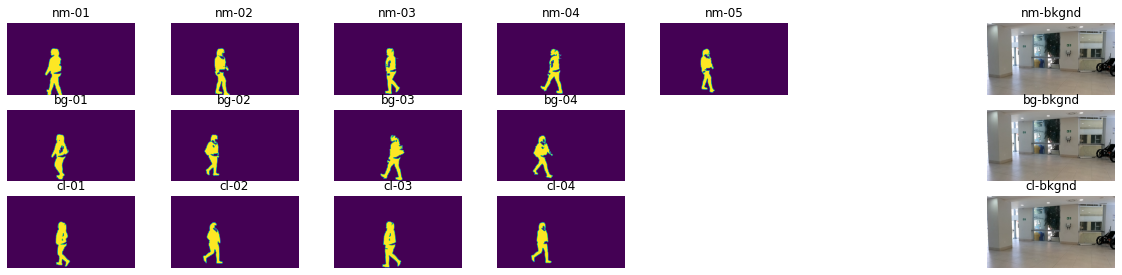

Showing subject: 005 view: 060


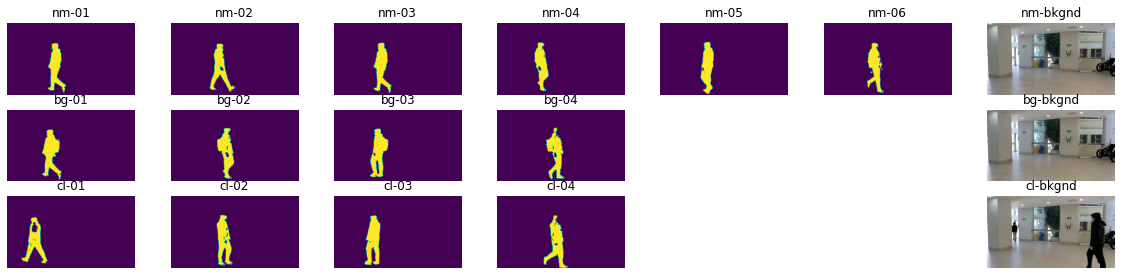

Showing subject: 007 view: 060


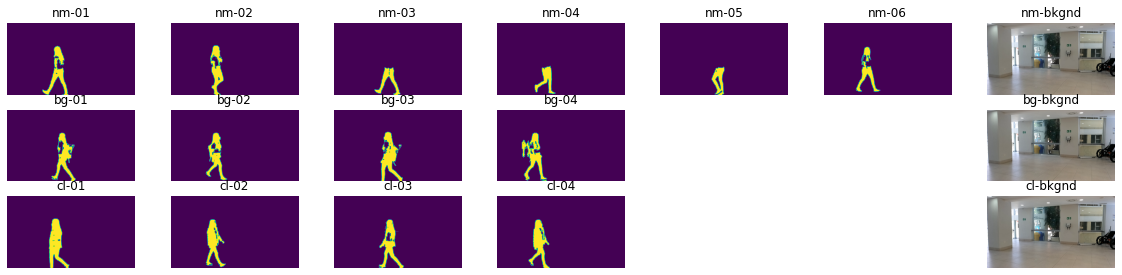

SHOWING VIEW: 075
Showing subject: 001 view: 075


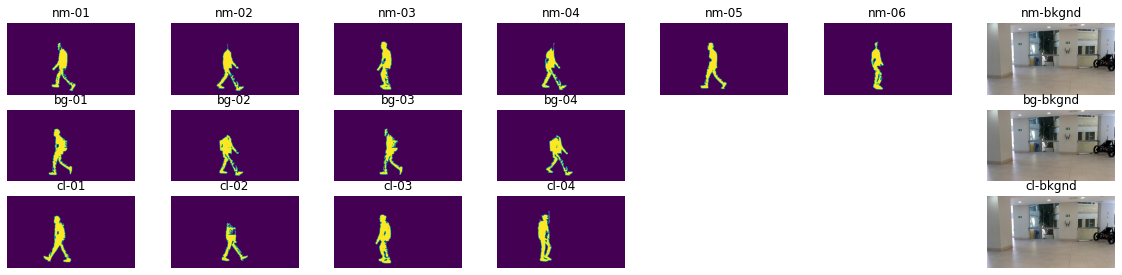

Showing subject: 002 view: 075


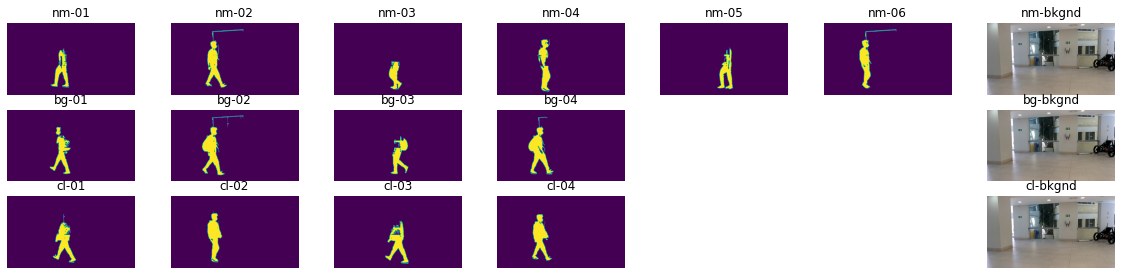

Showing subject: 003 view: 075


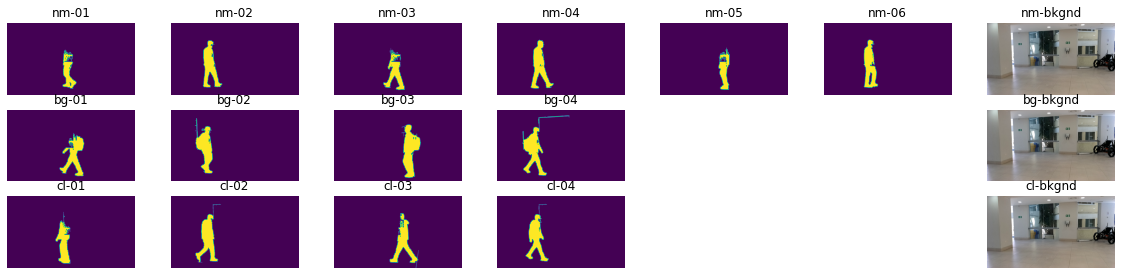

Showing subject: 004 view: 075


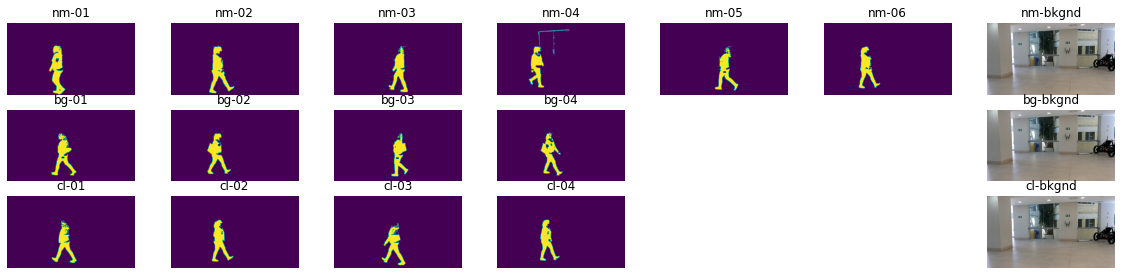

Showing subject: 005 view: 075


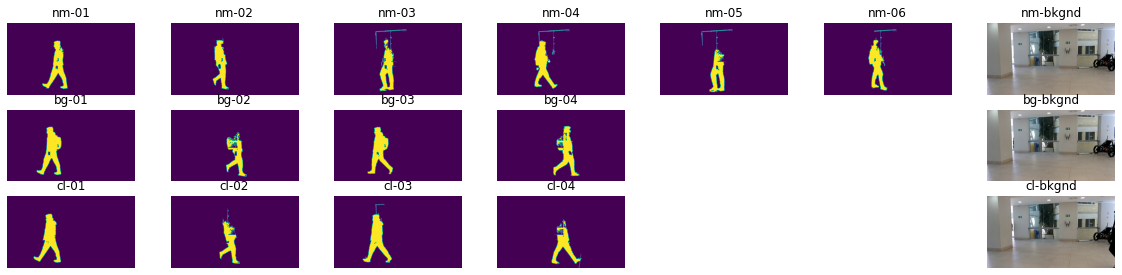

Showing subject: 007 view: 075


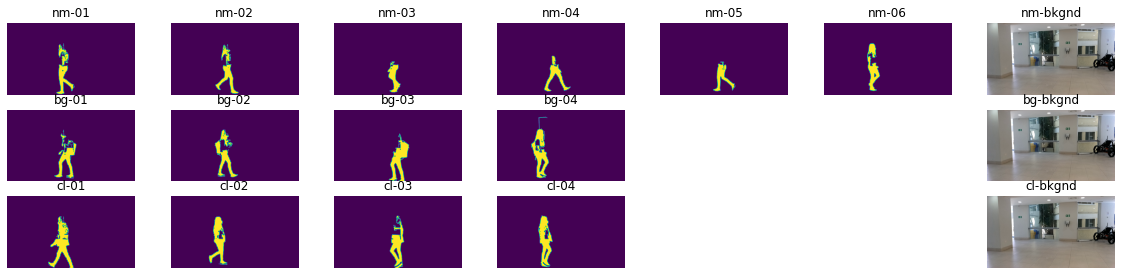

SHOWING VIEW: 090
Showing subject: 001 view: 090


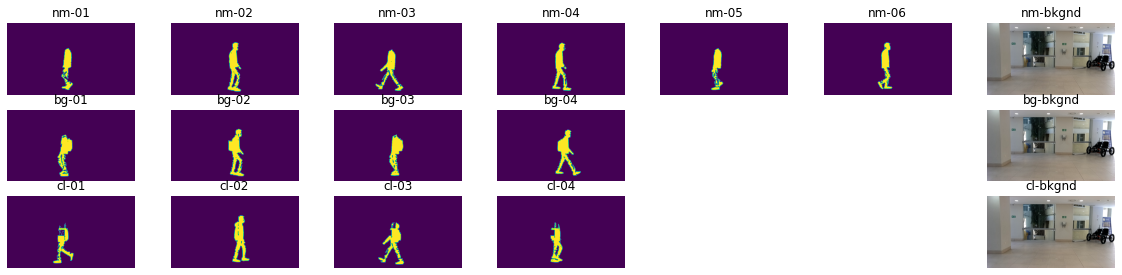

Showing subject: 002 view: 090


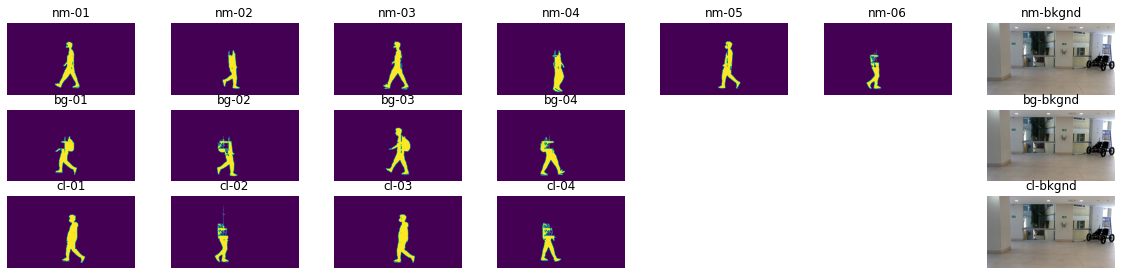

Showing subject: 003 view: 090


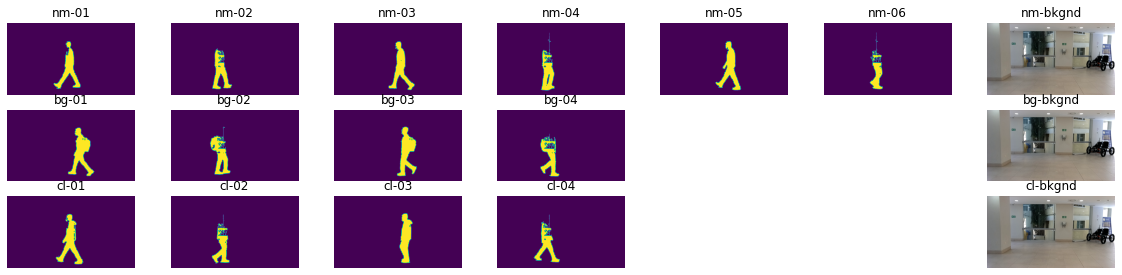

Showing subject: 004 view: 090


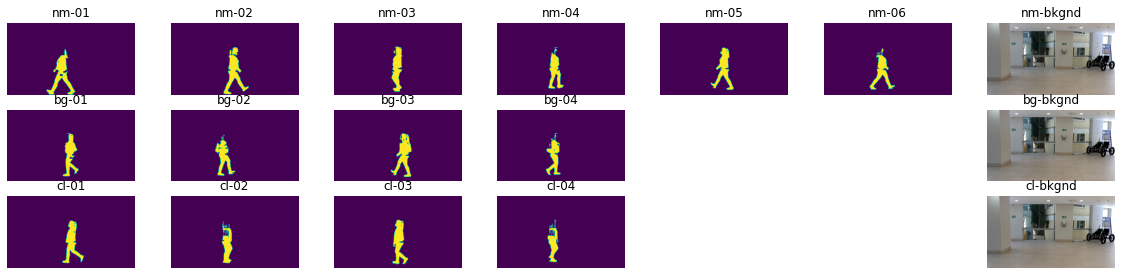

Showing subject: 005 view: 090


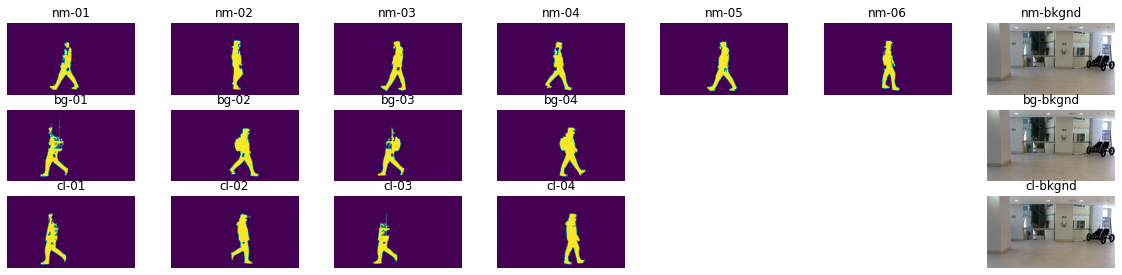

Showing subject: 007 view: 090


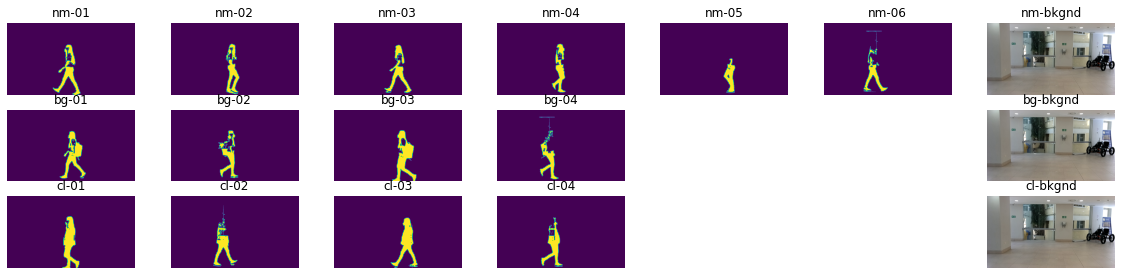

SHOWING VIEW: 105
Showing subject: 001 view: 105


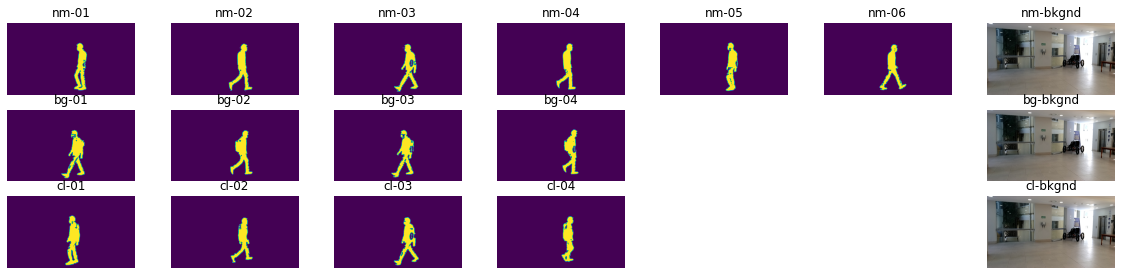

Showing subject: 002 view: 105


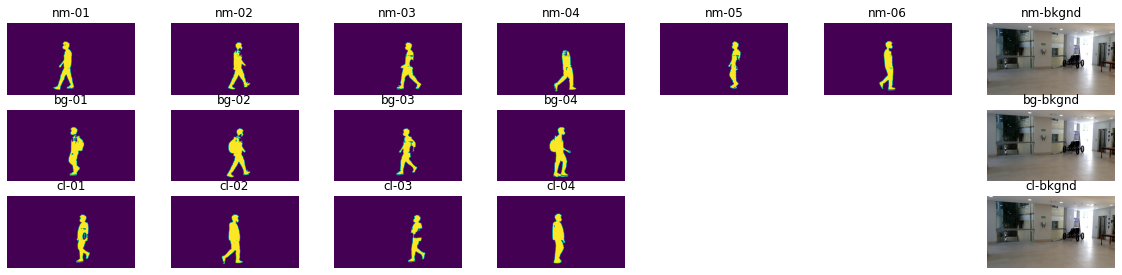

Showing subject: 003 view: 105


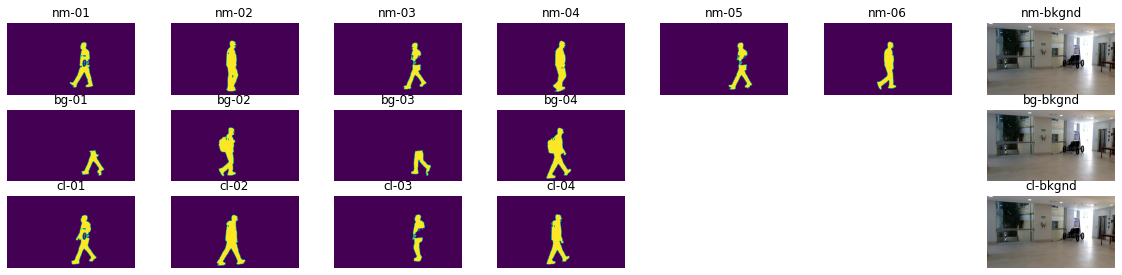

Showing subject: 004 view: 105


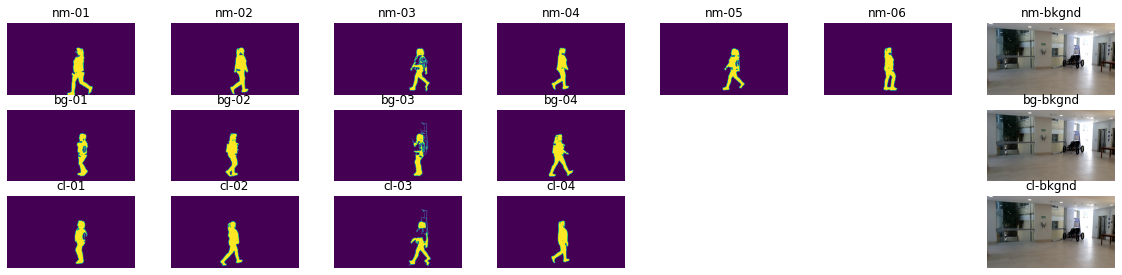

Showing subject: 005 view: 105


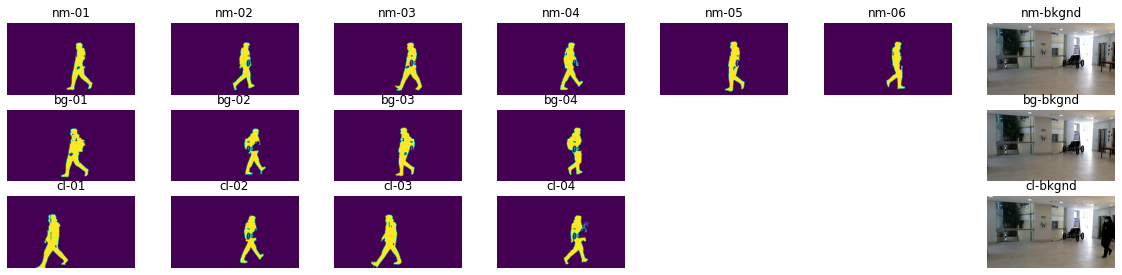

Showing subject: 007 view: 105


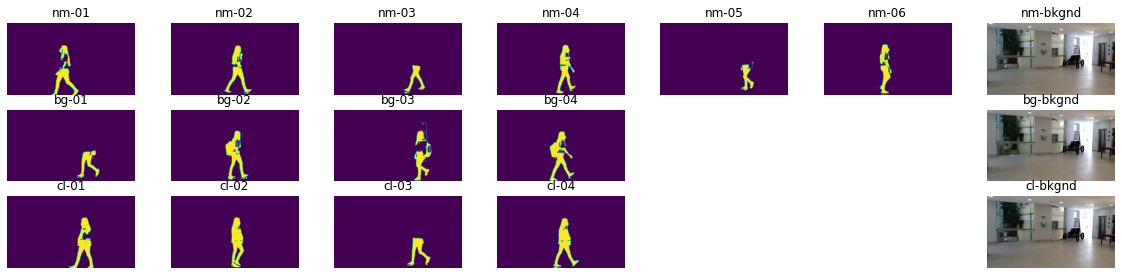

SHOWING VIEW: 120
Showing subject: 001 view: 120


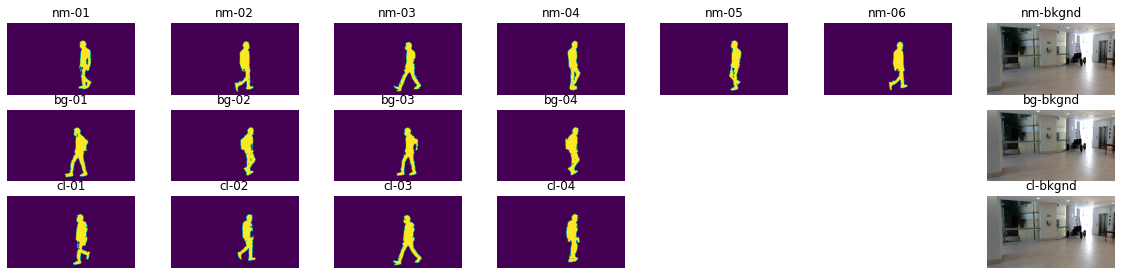

Showing subject: 002 view: 120


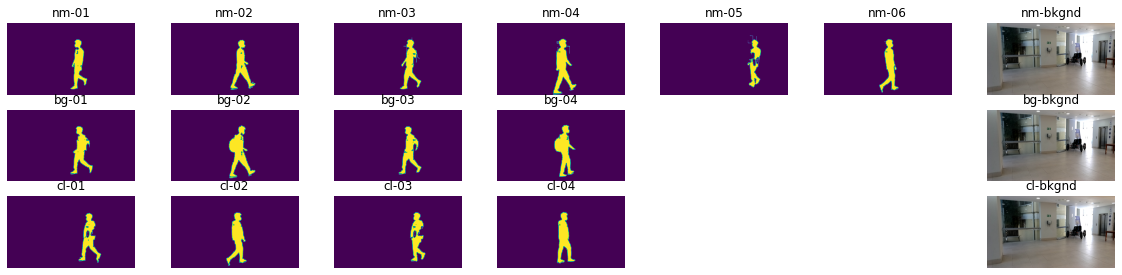

Showing subject: 003 view: 120


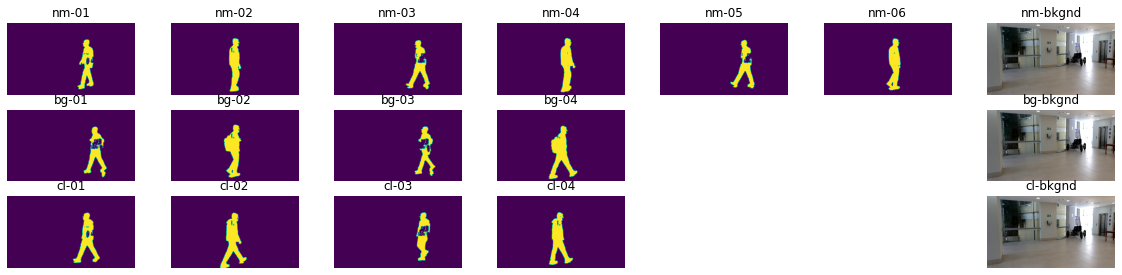

Showing subject: 004 view: 120


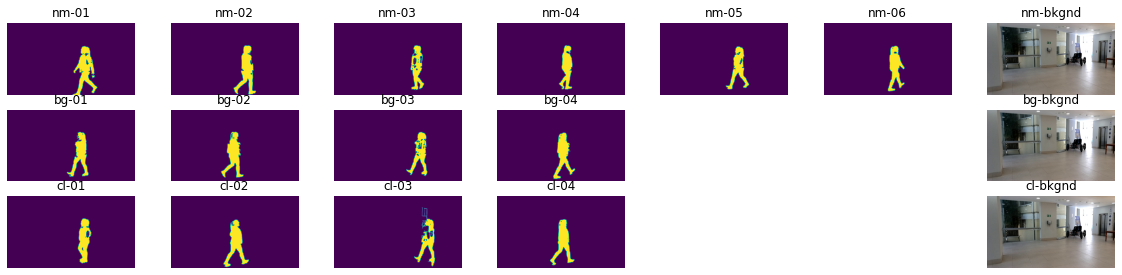

Showing subject: 005 view: 120


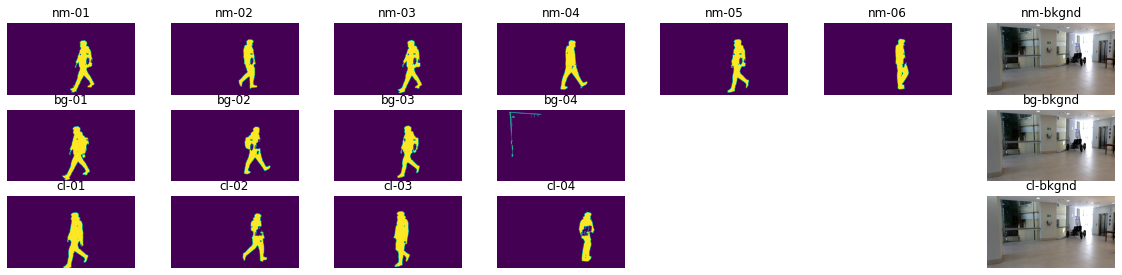

Showing subject: 007 view: 120


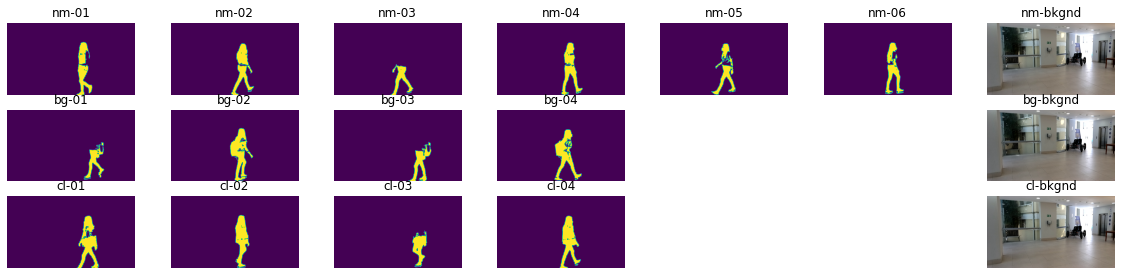

In [9]:
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    print(f'SHOWING VIEW: {view}')
    subjects = sorted(os.listdir(frames_dir))
    for subject in subjects:
#     for subject in ['023']:
        print(f'Showing subject: {subject} view: {view}')

        plt.figure(figsize=(20, 4.5))
#         plt.subplots_adjust(wspace=0.1, hspace=0.01)
        for j, walk in enumerate(['nm', 'bg', 'cl']):
#         for j, walk in enumerate(['nm']):

            nplot = j*7 + 1
            rseqs_dir = os.path.join(frames_dir, subject, walk)
            mseqs_dir = os.path.join(masks_dir, subject, walk)
            
            seqs = sorted(os.listdir(rseqs_dir))
            bkgnd_path = os.path.join(frames_dir, subject, f'{walk}-background.png')
#             print(bkgnd_path)
            bkgnd = cv2.imread(bkgnd_path)
            plt.subplot(3, 7, 7*(j+1)); plt.imshow(bkgnd[:,:,::-1]); plt.title(f'{walk}-bkgnd'); plt.axis('off')
            for i, seq in enumerate(seqs):
                try:
    #                 rgb = cv2.imread(os.path.join(rseqs_dir, seq, f'{str(40).zfill(4)}.png'))
                    msk = cv2.imread(os.path.join(mseqs_dir, seq, f'{str(40).zfill(4)}.png'), 0)
    #                 plt.subplot(3, 7, nplot); plt.imshow(msk[:,:,::-1]); plt.title(seq); plt.axis('off')
                    plt.subplot(3, 7, nplot); plt.imshow(msk); plt.title(seq); plt.axis('off')
                except:
                    print(f'Error opening')
                nplot+=1
        plt.show()

In [1]:
def GEI_generator(sil_file, size = 64,debug = False):
    lfiles = sorted(os.listdir(sil_file))
    stack_GEI = []
    if debug:
        print(f'Number of images: {len(lfiles)}')
        plt.figure(figsize=(20,int(len(lfiles)/10)))
    for idimg, path in enumerate(lfiles):
        if debug: 
            plt.subplot((len(lfiles)//15)+1,15, idimg+1)
        img = cv2.imread(os.path.join(sil_file, path), 0)
        # Silhouette extraction
        if img.mean() > 2:
            x, y, w, h = cv2.boundingRect(img)
            silhouette = img[y:y+h,x:x+w]

            # Normalizae silhouette
            factor = size/max(silhouette.shape)
            height = round(factor*silhouette.shape[0])
            width = round(factor*silhouette.shape[1])
            try:
                if(height>width):
                    nor_sil = cv2.resize(silhouette,(width,height))
                    # We add a background of the shape size x size
                    # We take the upper part of the body to center the image and avoid the legs
                    portion_body = 0.3
                    moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
                    w = round(moments['m10']/moments['m00'])
                    background = np.zeros((size, size))
                    shift = round((size/2)-w)
                    if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
                    background[:,shift:nor_sil.shape[1]+shift] = nor_sil

                    stack_GEI.append(background)
                    if debug:
                        plt.imshow(background,'gray'); plt.title(idimg);plt.axis('off')
                        # plt.subplots_adjust(wspace=0.05, hspace=0.01)
            except:
                print(f'Error {os.path.join(sil_file, path)}')
    if stack_GEI == []:
        GEI = np.zeros((size, size))
        print('No Files Found')
        return False, GEI, stack_GEI
    else: 
        GEI = np.mean(np.array(stack_GEI),axis=0)
        return True, GEI, stack_GEI
    

In [11]:
images_dir = '/home/christian/Documents/Datasets/OAKGait8/frames/'
representations_dir = '/home/christian/Documents/Datasets/OAKGait8/full_walk_representations/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
views = ['060','075','090','105','120']
verbose = False

In [14]:
for view in views:
    frames_dir = os.path.join(images_dir, view, frs_dir)
    masks_dir = os.path.join(images_dir, view, mks_dir)
    rep_dir = os.path.join(representations_dir, view)
    print(f'GENERATING GAIT REPRESENTATIONS FROM VIEW: {view}')
    subjects = sorted(os.listdir(os.path.join(images_dir, view, frs_dir)))
    for subject in subjects:
#     for subject in ['022', '023', '025']:
        print(f'Processing subject: {subject} view: {view}')
        sub_GEI_dir = os.path.join(rep_dir, subject)
        create_dir(sub_GEI_dir, force=True)

        for j, walk in enumerate(['nm', 'bg', 'cl']):
#         for j, walk in enumerate(['nm']):

            seq_dir = os.path.join(masks_dir, subject, walk)
            seqs = sorted(os.listdir(seq_dir))
            print(f'Processing: {seqs}')
            for s, seq in enumerate(seqs):
                seq_frames_dir = os.path.join(seq_dir, seq)
                ret, GEI, _ = GEI_generator(seq_frames_dir)
                if ret:
                    GEI_name = os.path.join(sub_GEI_dir, f'{walk}-{str(s).zfill(2)}.png')
                    cv2.imwrite(GEI_name, GEI)
                else:
                    break

GENERATING GAIT REPRESENTATIONS FROM VIEW: 060
Processing subject: 001 view: 060
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 002 view: 060
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 003 view: 060
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 004 view: 060
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl-01', 'cl-02', 'cl-03', 'cl-04']
Processing subject: 005 view: 060
Processing: ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
Processing: ['bg-01', 'bg-02', 'bg-03', 'bg-04']
Processing: ['cl

SHOWING VIEW: 060
Showing subject: 001 view: 060


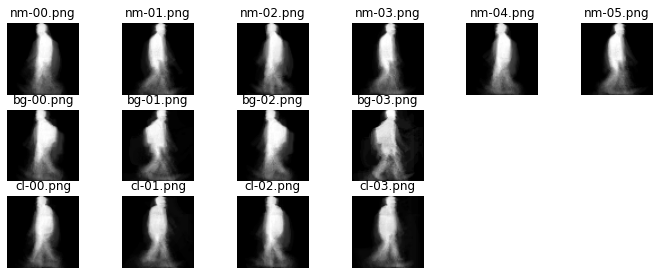

Showing subject: 002 view: 060


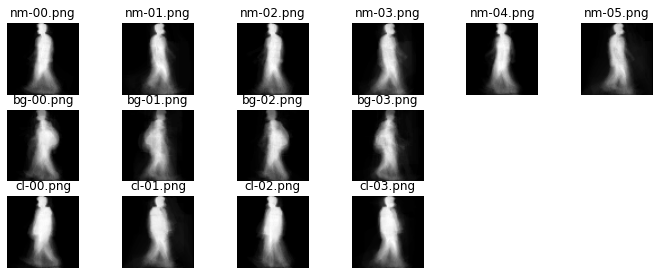

Showing subject: 003 view: 060


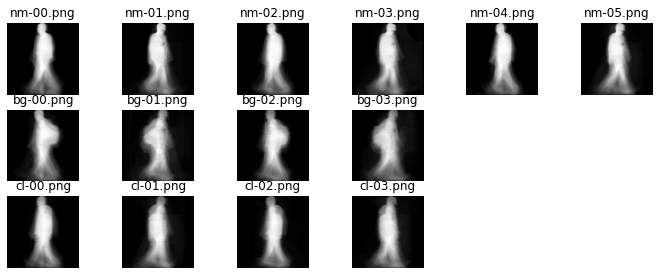

Showing subject: 004 view: 060


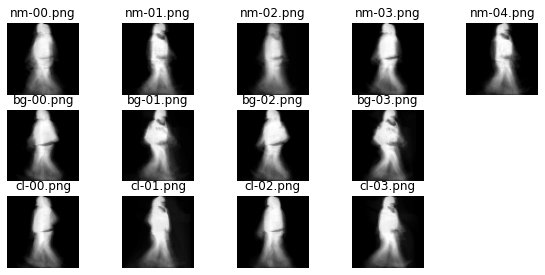

Showing subject: 005 view: 060


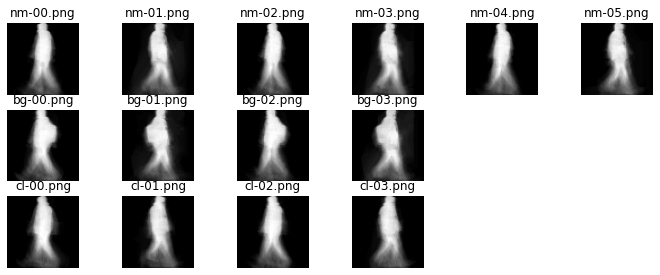

Showing subject: 007 view: 060


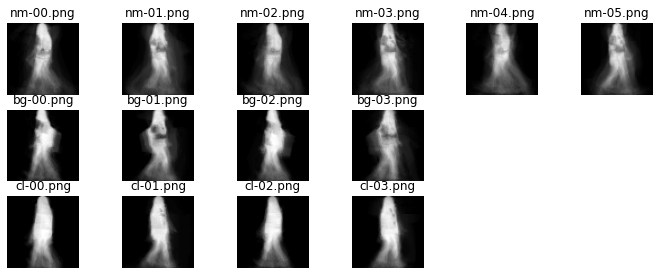

SHOWING VIEW: 075
Showing subject: 001 view: 075


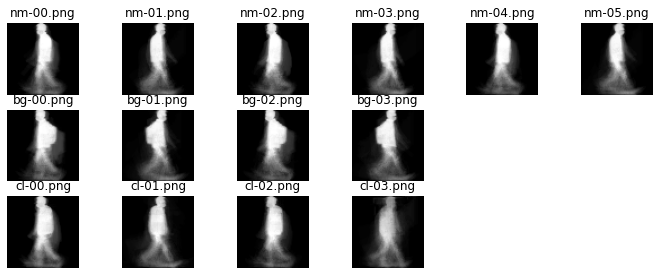

Showing subject: 002 view: 075


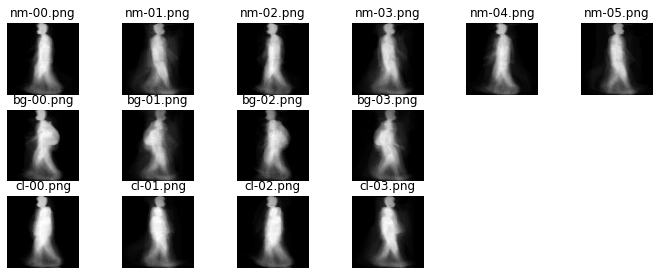

Showing subject: 003 view: 075


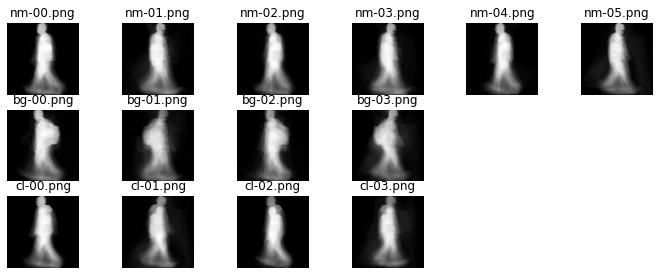

Showing subject: 004 view: 075


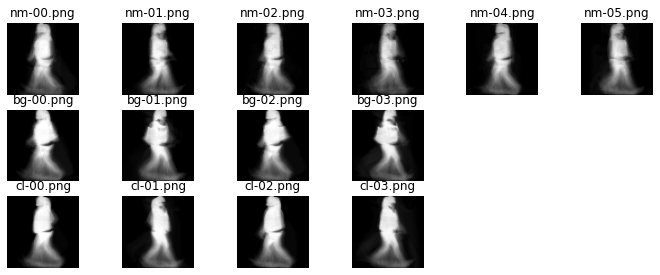

Showing subject: 005 view: 075


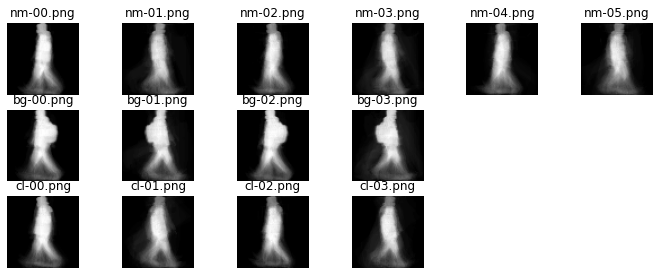

Showing subject: 007 view: 075


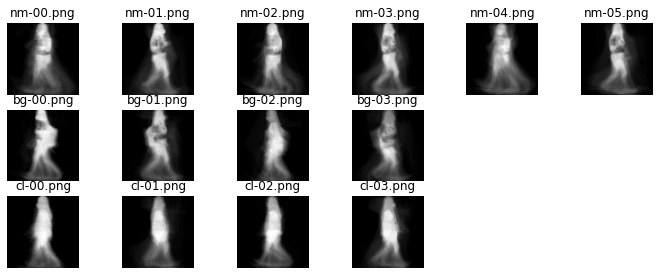

SHOWING VIEW: 090
Showing subject: 001 view: 090


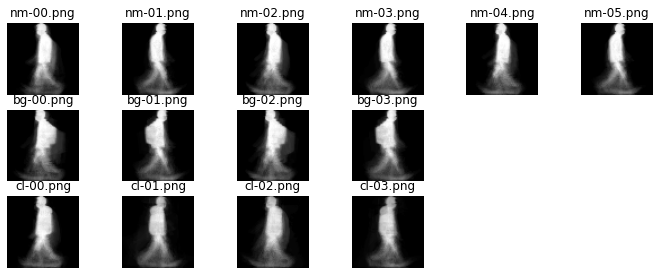

Showing subject: 002 view: 090


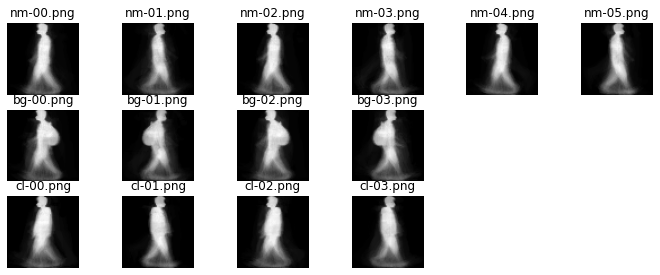

Showing subject: 003 view: 090


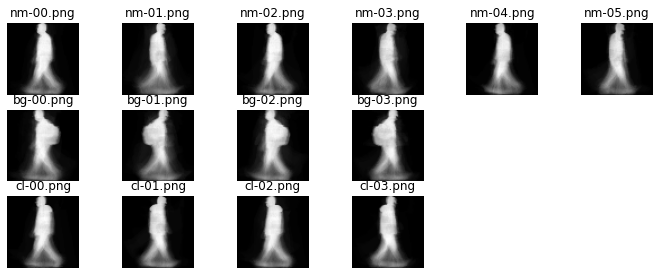

Showing subject: 004 view: 090


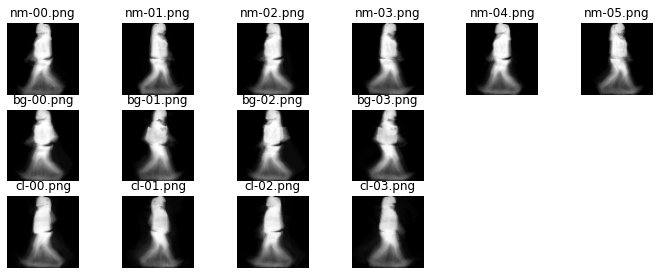

Showing subject: 005 view: 090


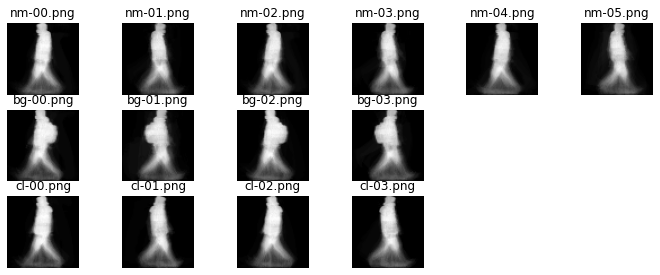

Showing subject: 007 view: 090


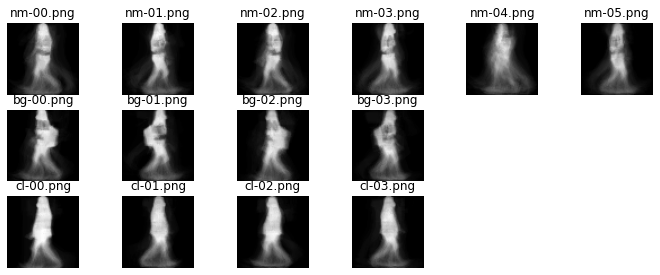

SHOWING VIEW: 105
Showing subject: 001 view: 105


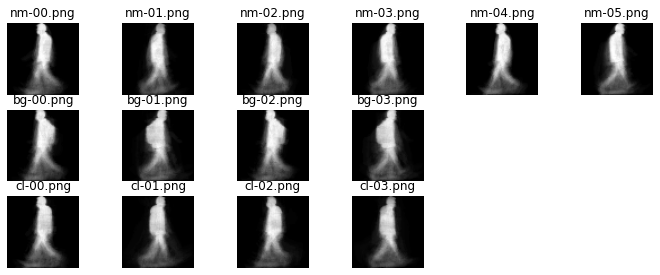

Showing subject: 002 view: 105


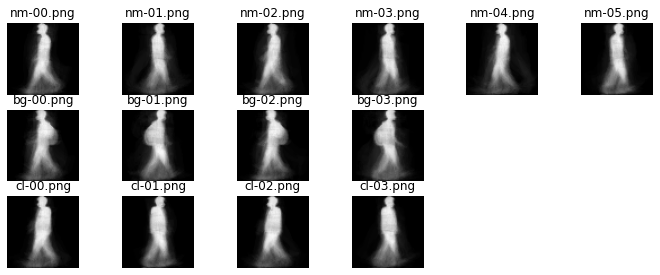

Showing subject: 003 view: 105


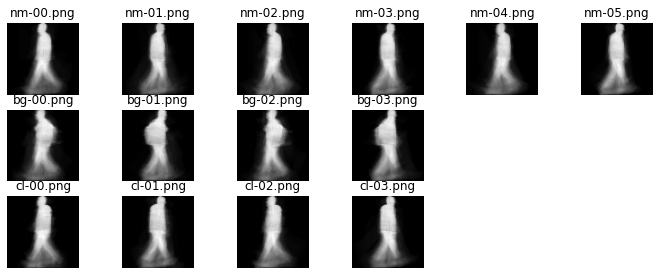

Showing subject: 004 view: 105


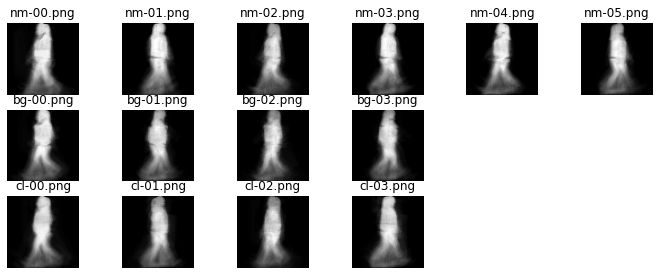

Showing subject: 005 view: 105


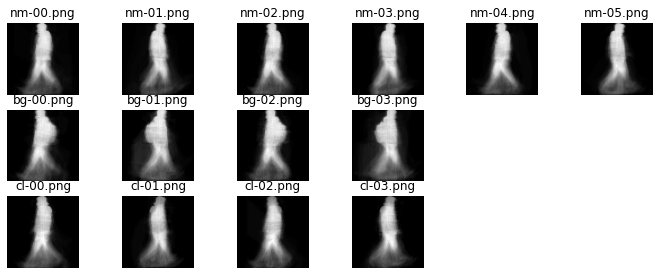

Showing subject: 007 view: 105


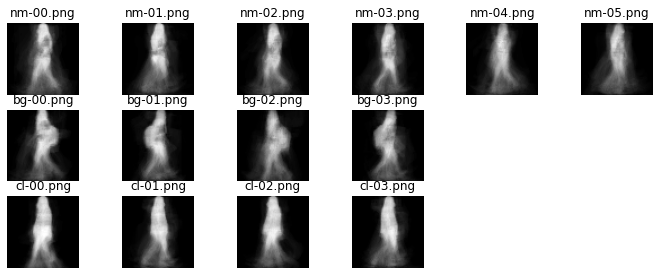

SHOWING VIEW: 120
Showing subject: 001 view: 120


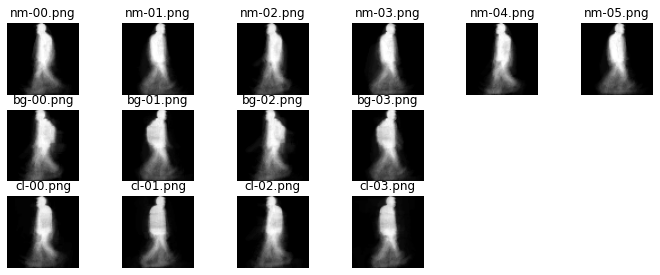

Showing subject: 002 view: 120


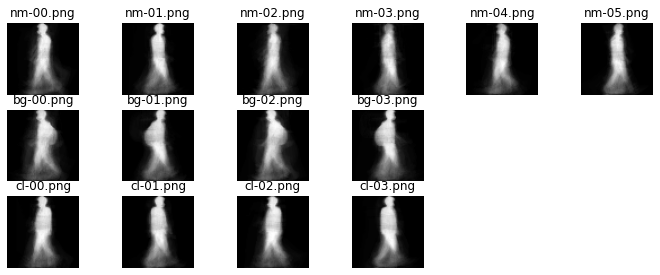

Showing subject: 003 view: 120


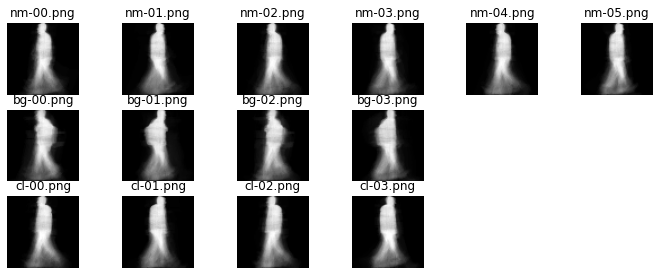

Showing subject: 004 view: 120


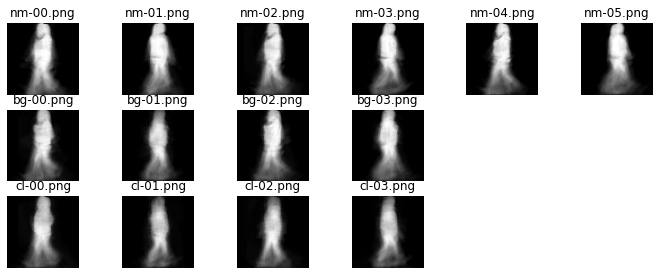

Showing subject: 005 view: 120


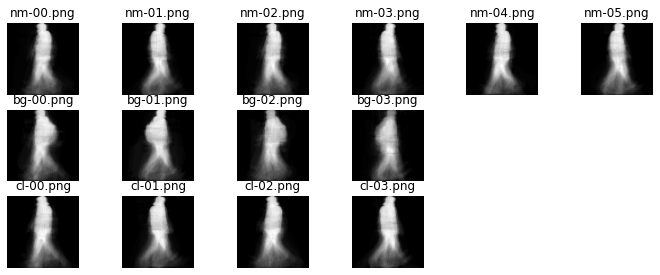

Showing subject: 007 view: 120


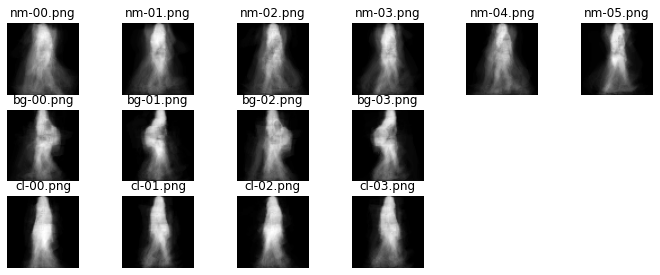

In [15]:
for view in views:
    print(f'SHOWING VIEW: {view}')
    rep_dir = os.path.join(representations_dir, view)
    subjects = sorted(os.listdir(rep_dir))

    for subject in subjects:
#     for subject in ['002']:
        print(f'Showing subject: {subject} view: {view}')
        plt.figure(figsize=(12, 4.5))
#         plt.subplots_adjust(wspace=0.01, hspace=0.01)

        nsec = 1
        for j, walk in enumerate(['nm', 'bg', 'cl']):
            seqs = sorted(glob(os.path.join(representations_dir, view, subject)+f'/{walk}*'))[:nclips[walk]]
            for i, seq in enumerate(seqs):
                GEI = cv2.imread(seq)
                
                plt.subplot(3, 6, j*6+(i+1)); plt.imshow(GEI, 'gray'); plt.title(seq.split('/')[-1]); plt.axis('off')
        plt.show()

In [6]:
representations_dir = '/home/christian/Documents/Datasets/OAKGait8/representations/'
training_path = '/home/christian/Documents/Datasets/OAKGait8/training_representations/'
test_path = '/home/christian/Documents/Datasets/OAKGait8/test_representations/'
frs_dir = 'rgb/'
mks_dir = 'masks/'
verbose = False
views = ['060', '075','090','105','120']

In [26]:
def GEI2MGEI(GEI, fr, to):
    GEI[fr:to]==0
    return GEI

In [29]:
#training = {'data':[], 'labels': [], 'seqs':['nm-00', 'nm-01', 'nm-02', 'nm-03', 'cl-00', 'bg-00']}

#testing = {'nm':{'data':[], 'labels': [], 'seqs': ['nm-04', 'nm-05']},
#            'cl':{'data':[], 'labels': [], 'seqs': ['cl-01', 'cl-02', 'cl-03']},
#            'bg':{'data':[], 'labels': [], 'seqs': ['bg-01', 'bg-02', 'bg-03']}}

training = {'data':[], 'labels': [], 'seqs':['nm-00', 'nm-01', 'nm-02', 'nm-03', 'cl-00', 'bg-00','cl-02', 'cl-03','bg-02', 'bg-03']}

testing = {'nm':{'data':[], 'labels': [], 'seqs': ['nm-04']},
            'cl':{'data':[], 'labels': [], 'seqs': ['cl-01']},
            'bg':{'data':[], 'labels': [], 'seqs': ['bg-01']}}
           
h, w = 64, 64
fr = int(h * 0.15)
to = int(h * 0.60)
for view in views:
    rep_dir = os.path.join(representations_dir, view)
    print(f'GENERATING GAIT REPRESENTATIONS FROM VIEW: {view}')
    subjects = sorted(os.listdir(rep_dir))
    skip_sub = ['022', '023']
    
    for subject in subjects:
#     for subject in ['001']:
        if subject not in skip_sub:
            print(f'Processing subject: {subject} view: {view}')
            sub_GEI_dir = os.path.join(rep_dir, subject)

            for seq_tr in training['seqs']:
                walk = seq_tr.split('-')[0]
                GEI_name = os.path.join(sub_GEI_dir, f'{seq_tr}.png')
                GEI = GEI2MGEI(cv2.imread(GEI_name, 0),fr,to)
                GEI_image_name_path = subject+'/'+subject+'_'+view+'_'+seq_tr+'.png'
                print(GEI_image_name_path)
                cv2.imwrite(os.path.join(training_path ,GEI_image_name_path), GEI )
                #training['data'].append(GEI)
                training['labels'].append(int(subject))
    #             print(GEI_name)

            for walk, dic in testing.items():
                for seq_tr in dic['seqs']:
                    GEI_name = os.path.join(sub_GEI_dir, f'{seq_tr}.png')
                    #print(GEI_name, end='\r')
                    GEI = GEI2MGEI(cv2.imread(GEI_name, 0),fr, to)
                    GEI_image_name_path_test = subject+'/'+subject+'_'+view+'_'+seq_tr+'.png'
                    cv2.imwrite(os.path.join(test_path ,GEI_image_name_path_test), GEI )
                    #dic['data'].append(GEI)
                    dic['labels'].append(int(subject))

GENERATING GAIT REPRESENTATIONS FROM VIEW: 060
Processing subject: 001 view: 060
001/001_060_nm-00.png
001/001_060_nm-01.png
001/001_060_nm-02.png
001/001_060_nm-03.png
001/001_060_cl-00.png
001/001_060_bg-00.png
001/001_060_cl-02.png
001/001_060_cl-03.png
001/001_060_bg-02.png
001/001_060_bg-03.png
Processing subject: 002 view: 060
002/002_060_nm-00.png
002/002_060_nm-01.png
002/002_060_nm-02.png
002/002_060_nm-03.png
002/002_060_cl-00.png
002/002_060_bg-00.png
002/002_060_cl-02.png
002/002_060_cl-03.png
002/002_060_bg-02.png
002/002_060_bg-03.png
Processing subject: 003 view: 060
003/003_060_nm-00.png
003/003_060_nm-01.png
003/003_060_nm-02.png
003/003_060_nm-03.png
003/003_060_cl-00.png
003/003_060_bg-00.png
003/003_060_cl-02.png
003/003_060_cl-03.png
003/003_060_bg-02.png
003/003_060_bg-03.png
Processing subject: 004 view: 060
004/004_060_nm-00.png
004/004_060_nm-01.png
004/004_060_nm-02.png
004/004_060_nm-03.png
004/004_060_cl-00.png
004/004_060_bg-00.png
004/004_060_cl-02.png
004

In [167]:
import tensorflow as tf

In [621]:
img_height = 64
img_width = 64
batch_size = 8

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    color_mode='grayscale',
    label_mode = "categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode = "categorical",
)

Found 300 files belonging to 6 classes.
Found 90 files belonging to 6 classes.


In [622]:
IMG_SIZE = 64
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255),
  layers.RandomTranslation(
    (-0.1, 0.1),
    (-0.1, 0.1)),
])

In [623]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),
])

In [624]:
classes = ["001","002","003","004","005","007"]
print(classes)

['001', '002', '003', '004', '005', '007']


In [625]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [626]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)

In [627]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis("off")
  plt.tight_layout()
  plt.show()

(8, 64, 64, 1)


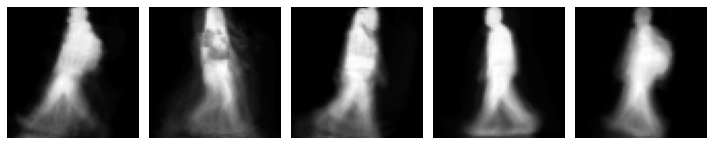

In [628]:
sample_training_images, _= next(iter(train_ds))
print(sample_training_images.shape)
plotImages(sample_training_images[:5])

In [629]:
model_convolutional = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(128, (3,3), activation = "relu"),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Conv2D(64, (3,3), activation = "relu"),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(64, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(32, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(len(classes), activation = "softmax")
])

model_convolutional.build((None, 64, 64, 1))
model_convolutional.summary()

model_convolutional.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_convolutional = model_convolutional.fit(
    train_ds,
    epochs = 20,
)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1071 (Conv2D)        (None, 62, 62, 128)       1280      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 31, 31, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_1072 (Conv2D)        (None, 29, 29, 64)        73792     
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 12544)             0         
                                                                 
 dense_97 (Dense)            (None, 64)              

In [630]:
for image_batch, label_batch in iter(test_ds):
    loss, accuracy = model_convolutional.evaluate(image_batch, label_batch)

1/1 [==============================] - 0s 33ms/step - loss: 0.0101 - accuracy: 1.0000


In [632]:
def visualizacion_resultados(history):
  epochs = [i for i in range(20)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
  ax[0].set_title("Entrenamiento & validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
  ax[1].set_title("Entrenamiento & validación Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

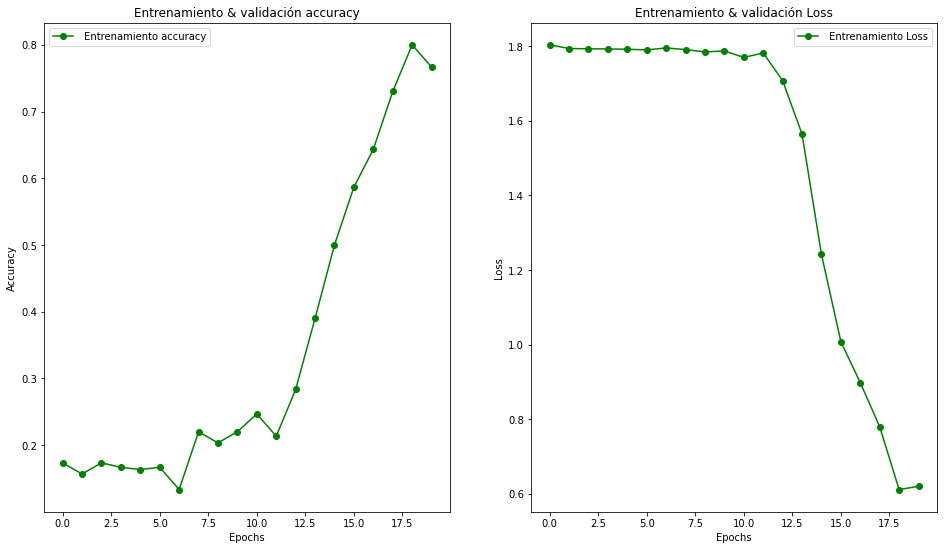

In [633]:
visualizacion_resultados(history_convolutional)

1/1 [==============================] - 0s 106ms/step
tf.Tensor([5 0 0 3 3 0 5 2], shape=(8,), dtype=int64)
tf.Tensor([5 0 1 3 1 0 5 2], shape=(8,), dtype=int64)
1/1 [==============================] - 0s 39ms/step
tf.Tensor([0 2 2 1 5 5 1 0], shape=(8,), dtype=int64)
tf.Tensor([1 2 2 1 5 5 1 5], shape=(8,), dtype=int64)
1/1 [==============================] - 0s 40ms/step
tf.Tensor([2 0 2 0 4 2 3 5], shape=(8,), dtype=int64)
tf.Tensor([2 0 2 0 4 2 3 5], shape=(8,), dtype=int64)
1/1 [==============================] - 0s 42ms/step
tf.Tensor([4 3 2 5 0 2 2 1], shape=(8,), dtype=int64)
tf.Tensor([4 3 2 5 0 2 2 1], shape=(8,), dtype=int64)
1/1 [==============================] - 0s 42ms/step
tf.Tensor([4 0 3 2 4 3 4 0], shape=(8,), dtype=int64)
tf.Tensor([4 0 3 2 4 3 4 1], shape=(8,), dtype=int64)
1/1 [==============================] - 0s 51ms/step
tf.Tensor([4 0 0 3 3 0 2 3], shape=(8,), dtype=int64)
tf.Tensor([4 0 0 3 3 0 2 3], shape=(8,), dtype=int64)
1/1 [==============================] - 

<AxesSubplot:>

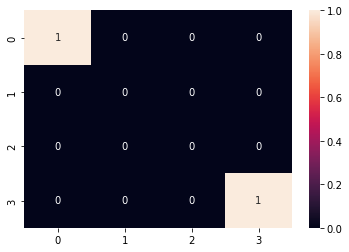

In [634]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

for image_batch, label_batch in iter(test_ds):
  predictions = tf.argmax(model_convolutional.predict(image_batch), axis=1)
  label_batch = tf.argmax(label_batch, axis=1)
  print(predictions)
  print(label_batch)
  cf_matrix = tf.math.confusion_matrix(label_batch, predictions)


sns.heatmap(cf_matrix, annot=True)

In [658]:
model_convolutional.save('models/cnn_gait_recognition.h5')
model_convolutional.save("saved_model/cnn_gait_recognition")

INFO:tensorflow:Assets written to: saved_model/cnn_gait_recognition/assets


INFO:tensorflow:Assets written to: saved_model/cnn_gait_recognition/assets


In [659]:
cnn_gait_recognition = tf.keras.models.load_model('models/cnn_gait_recognition.h5')
cnn_gait_recognition.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1071 (Conv2D)        (None, 62, 62, 128)       1280      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 31, 31, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_1072 (Conv2D)        (None, 29, 29, 64)        73792     
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 12544)             0         
                                                                 
 dense_97 (Dense)            (None, 64)              

In [637]:
for image_batch, label_batch in iter(test_ds):
    loss, accuracy = cnn_gait_recognition.evaluate(image_batch, label_batch)

1/1 [==============================] - 0s 29ms/step - loss: 0.9534 - accuracy: 0.5000


(1, 64, 64)
1/1 [==============================] - 0s 99ms/step
[[0. 0. 0. 0. 0. 1.]]
Sujeto detectado 006


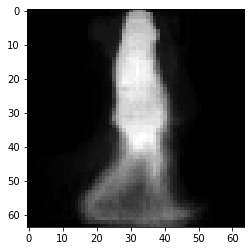

In [640]:
image = cv2.imread('/home/christian/OAKGait8/test_representations/007/007_090_cl-01.png', cv2.IMREAD_GRAYSCALE)
GEI = cv2.resize(image, (64, 64))

GEI = tf.expand_dims(GEI, axis=0)
print(GEI.shape)

preds = cnn_gait_recognition.predict(GEI)
print(preds)
subject = str(np.argmax(preds)+1)
print("Sujeto detectado 00"+subject)

plt.imshow(GEI[0], cmap="gray")

1/1 [==============================] - 0s 77ms/step
[[0. 0. 1. 0. 0. 0.]]
Sujeto detectado 003


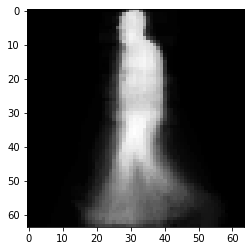

In [429]:
image = cv2.imread('/home/christian/OAKGait8/test_representations/003/003_120_nm-04.png')
GEI_resized = cv2.resize(image, (64, 64))
GEI = cv2.cvtColor(GEI_resized, cv2.COLOR_BGR2GRAY)
GEI = tf.expand_dims(GEI, axis=0)
preds = model_convolutional.predict(GEI)
print(preds)
subject = str(np.argmax(preds)+1)
print("Sujeto detectado 00"+subject)

plt.imshow(GEI[0], cmap="gray")

1/1 [==============================] - 0s 27ms/step
[[1. 0. 0. 0. 0. 0.]]
Sujeto detectado 001


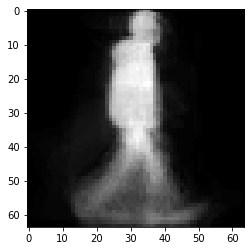

In [641]:
image = cv2.imread('/home/christian/OAKGait8/test_representations/001/001_090_cl-01.png')
GEI_resized = cv2.resize(image, (64, 64))
GEI = cv2.cvtColor(GEI_resized, cv2.COLOR_BGR2GRAY)
GEI = tf.expand_dims(GEI, axis=0)
preds = cnn_gait_recognition.predict(GEI)
print(preds)
subject = str(np.argmax(preds)+1)
print("Sujeto detectado 00"+subject)

plt.imshow(GEI[0], cmap="gray")

1/1 [==============================] - 0s 24ms/step
[[0. 0. 0. 0. 0. 1.]]
Sujeto detectado 006


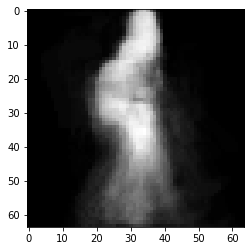

In [570]:
image = cv2.imread('/home/christian/OAKGait8/test_representations/007/007_120_bg-01.png')
GEI_resized = cv2.resize(image, (64, 64))
GEI = cv2.cvtColor(GEI_resized, cv2.COLOR_BGR2GRAY)
GEI = tf.expand_dims(GEI, axis=0)

preds = model_convolutional.predict(GEI)
print(preds)
subject = str(np.argmax(preds)+1)
print("Sujeto detectado 00"+subject)

plt.imshow(GEI[0], cmap="gray")

In [647]:
for layer in model_convolutional.layers:
    print(layer.name)

conv2d_1071
max_pooling2d_81
conv2d_1072
max_pooling2d_82
flatten_36
dense_97
dropout_61
dense_98
dropout_62
dense_99


In [655]:
last_conv_layer_name = "max_pooling2d_82"
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 24ms/step
[[0. 0. 1. 0. 0. 0.]]
Sujeto detectado 003


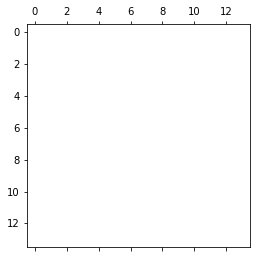

In [656]:
image = cv2.imread('/home/christian/OAKGait8/test_representations/003/003_120_nm-04.png')
GEI_resized = cv2.resize(image, (64, 64))
GEI = cv2.cvtColor(GEI_resized, cv2.COLOR_BGR2GRAY)
GEI = tf.expand_dims(GEI, axis=0)
preds = model_convolutional.predict(GEI)
print(preds)
subject = str(np.argmax(preds)+1)
print("Sujeto detectado 00"+subject)
heatmap = make_gradcam_heatmap(GEI, model_convolutional, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()


# Transfer Learning

In [541]:
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    #color_mode='grayscale',
    label_mode = "categorical",
    batch_size=batch_size)


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    batch_size=batch_size,
    #color_mode='grayscale',
    label_mode = "categorical",
)

Found 300 files belonging to 6 classes.
Found 90 files belonging to 6 classes.


In [542]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),
])

In [543]:
IMG_SIZE = 150
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255),
  layers.RandomTranslation(
    (-0.1, 0.1),
    (-0.1, 0.1)),
])

In [544]:
classes = ["001","002","003","004","005","007"]
print(classes)

['001', '002', '003', '004', '005', '007']


In [545]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [546]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)

In [547]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis("off")
  plt.tight_layout()
  plt.show()

(44, 150, 150, 3)


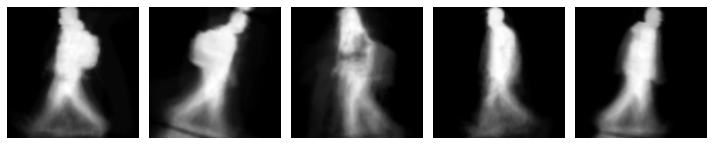

In [548]:
sample_training_images, _= next(iter(train_ds))
print(sample_training_images.shape)
plotImages(sample_training_images[:5])

In [552]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    include_top = False,
    input_tensor = tf.keras.layers.Input(shape = (150, 150, 3))
)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_973 (Conv2D)            (None, 74, 74, 32)   864         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_940 (Batch  (None, 74, 74, 32)  96          ['conv2d_973[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [553]:
last_layers= pre_trained_model.get_layer("mixed7")
last_output = last_layers.output

In [554]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(classes), activation= "softmax")(x)

model_keras = tf.keras.Model(pre_trained_model.input, x)

model_keras.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model_keras.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_973 (Conv2D)            (None, 74, 74, 32)   864         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_940 (Batch  (None, 74, 74, 32)  96          ['conv2d_973[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [555]:
history_keras = model_keras.fit(
    train_ds,
    epochs = 5
)

Epoch 1/5
5/5 [==============================] - 6s 601ms/step - loss: 2.8422 - accuracy: 0.2400
Epoch 2/5
5/5 [==============================] - 3s 649ms/step - loss: 1.6418 - accuracy: 0.3933
Epoch 3/5
5/5 [==============================] - 4s 645ms/step - loss: 1.0386 - accuracy: 0.5733
Epoch 4/5
5/5 [==============================] - 4s 624ms/step - loss: 0.7627 - accuracy: 0.7167
Epoch 5/5
5/5 [==============================] - 5s 935ms/step - loss: 0.5906 - accuracy: 0.7733


In [556]:
for image_batch, label_batch in iter(test_ds):
    loss, accuracy = model_keras.evaluate(image_batch, label_batch)

2/2 [==============================] - 2s 355ms/step - loss: 0.4112 - accuracy: 0.8750


1/1 [==============================] - 3s 3s/step - loss: 0.4317 - accuracy: 0.8462


In [557]:
def visualizacion_resultados(history):
  epochs = [i for i in range(20)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
  ax[0].set_title("Entrenamiento & validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
  ax[1].set_title("Entrenamiento & validación Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

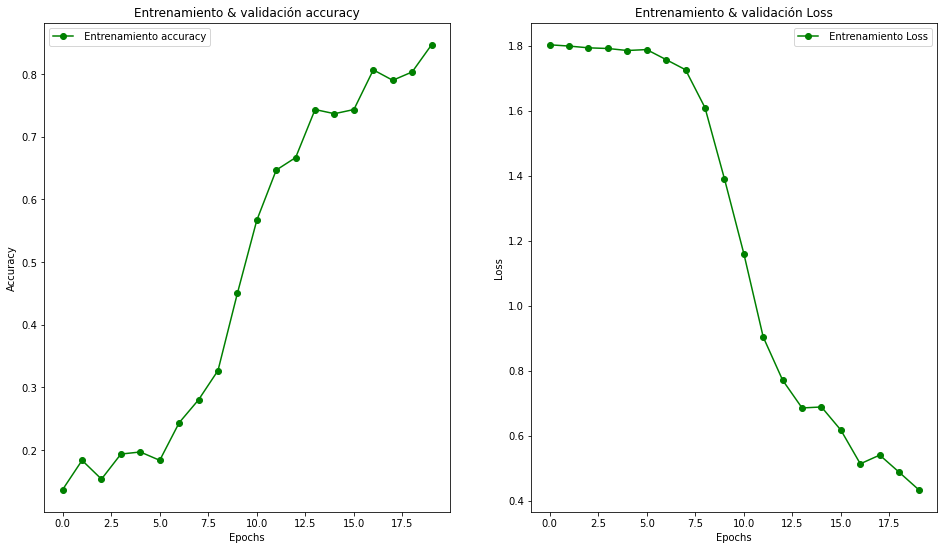

In [558]:
visualizacion_resultados(history_convolutional)

2/2 [==============================] - 2s 371ms/step
tf.Tensor(
[0 3 3 3 5 1 3 2 1 2 1 4 2 1 1 3 5 0 5 1 1 1 5 1 2 4 5 3 1 3 1 4 5 4 1 2 0
 5 3 4 3 3 3 4 0 5 0 1 0 4 5 4 4 3 2 3 1 1 2 4 1 3 4 3], shape=(64,), dtype=int64)
tf.Tensor(
[0 3 3 3 5 1 5 2 1 2 2 4 2 0 1 0 5 0 5 1 0 1 5 0 2 4 5 3 1 3 1 4 5 4 1 2 0
 5 3 4 3 3 3 4 0 5 0 1 0 4 5 4 4 3 2 2 1 0 2 4 1 3 4 3], shape=(64,), dtype=int64)
1/1 [==============================] - 2s 2s/step
tf.Tensor([3 1 5 4 1 3 1 0 4 3 2 5 1 5 5 1 0 1 2 5 2 0 5 4 5 2], shape=(26,), dtype=int64)
tf.Tensor([3 1 5 4 0 3 1 0 4 3 2 5 2 5 5 1 0 1 2 2 2 0 4 4 5 2], shape=(26,), dtype=int64)


<AxesSubplot:>

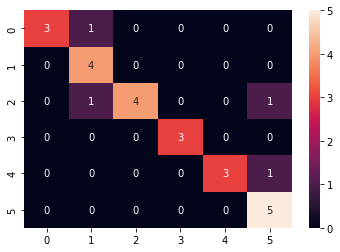

In [559]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

for image_batch, label_batch in iter(test_ds):
  predictions = tf.argmax(model_keras.predict(image_batch), axis=1)
  label_batch = tf.argmax(label_batch, axis=1)
  print(predictions)
  print(label_batch)
  cf_matrix = tf.math.confusion_matrix(label_batch, predictions)


sns.heatmap(cf_matrix, annot=True)

(1, 150, 150, 3)
1/1 [==============================] - 0s 54ms/step
[[0. 0. 0. 1. 0. 0.]]
Sujeto detectado 004


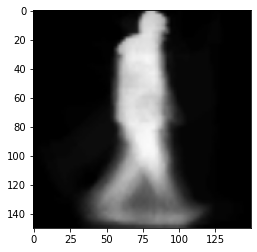

In [561]:
image = cv2.imread('/home/christian/OAKGait8/test_representations/003/003_090_cl-01.png', cv2.IMREAD_GRAYSCALE)
GEI = cv2.resize(image, (150, 150))
GEI = np.stack((GEI,)*3, axis=-1)

GEI = tf.expand_dims(GEI, axis=0)
print(GEI.shape)

preds = model_keras.predict(GEI)
print(preds)
subject = str(np.argmax(preds)+1)
print("Sujeto detectado 00"+subject)

plt.imshow(GEI[0], cmap="gray")

In [494]:
model_keras.save('saved_model/inceptionv3_gait_recognition')

INFO:tensorflow:Assets written to: saved_model/inceptionv3_gait_recognition/assets


INFO:tensorflow:Assets written to: saved_model/inceptionv3_gait_recognition/assets


In [496]:
inceptionv3_gait_recognition = tf.keras.models.load_model('saved_model/inceptionv3_gait_recognition')

(1, 150, 150, 3)
1/1 [==============================] - 0s 46ms/step
[[0. 0. 0. 1. 0. 0.]]
Sujeto detectado 004


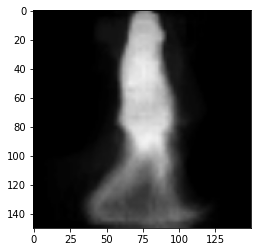

In [540]:
image = cv2.imread('/home/christian/OAKGait8/test_representations/007/007_090_cl-01.png', cv2.IMREAD_GRAYSCALE)
GEI = cv2.resize(image, (150, 150))
GEI = np.stack((GEI,)*3, axis=-1)

GEI = tf.expand_dims(GEI, axis=0)
print(GEI.shape)

preds = inceptionv3_gait_recognition.predict(GEI)
print(preds)
subject = str(np.argmax(preds)+1)
print("Sujeto detectado 00"+subject)

plt.imshow(GEI[0], cmap="gray")